### Integration with a quantum circuit and automatic differentiation

In this tutorial we exploit the automatic differentiation of our quantum model with respect to the input data to perform the calculation of integrals.

---

The core idea is inspired by [J. M. Cruz-Martinez et al.](https://iopscience.iop.org/article/10.1088/2058-9565/ad5866) and consists in training the derivative of a quantum circuit output w.r.t. input data to approximate the integrand function of a target integration problem. Once the derivative of the circuit is trained to approximate the integrand, then the original circuit can be used to compute any definite integral value by applying the fundamental theorem of the integral calculus.

$$ I = \int g(x) dx $$

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

2025-03-27 09:36:48.222606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743064608.241691  143302 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743064608.247467  143302 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


We consider a dummy 1-dimensional target here.

In [2]:
def integrand_function(x):
    return 1/2*x + torch.sin(3 * x)

def integral_function(x):
    return x ** 2 / 4 - torch.cos(3 * x)/3 

def definite_integral(xa, xb):
    return integral_function(xb) - integral_function(xa)

npoints = 30
nqubits = 1
nlayers = 5

In [3]:
x = torch.linspace(0, 2, npoints)
g = integrand_function(x)
I = integral_function(x)

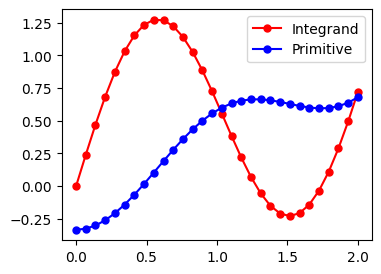

In [4]:
plt.figure(figsize=(4, 3))
plt.plot(x, g, label="Integrand", c="red", marker=".", markersize=10)
plt.plot(x, I, label="Primitive", c="blue", marker=".", markersize=10)
plt.legend()
plt.show()

Then we use a data reuploading strategy to upload the data into a quantum circuit, alternating data-encoding gates with trainable blocks of gates in our circuit. 

[Qibo 0.2.17|INFO|2025-03-27 09:38:21]: Using qiboml (pytorch) backend on cpu


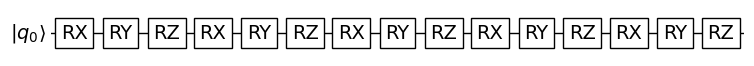

In [5]:
x_train = torch.linspace(0., 2., npoints, dtype=torch.float32).unsqueeze(1)
x_train = x_train.clone().detach().requires_grad_(True)
y_train = integrand_function(x_train)

set_backend("qiboml", platform="pytorch")


# Encoding layer
encoding_circ = PhaseEncoding(
    nqubits=nqubits, 
    encoding_gate=gates.RX
)

# Trainable layer
def trainable_circuit(entanglement=True):
    trainable_circ  = Circuit(nqubits)
    for q in range(nqubits):
        trainable_circ.add(gates.RY(q=q, theta=np.random.randn()))
        trainable_circ.add(gates.RZ(q=q, theta=np.random.randn()))
    if nqubits > 1 and entanglement:
        [trainable_circ.add(gates.CNOT(q%nqubits, (q+1)%nqubits) for q in range(nqubits))]
    return trainable_circ

# Decoding layer
decoding_circ = Expectation(
    nqubits=nqubits, 
    backend=construct_backend("qiboml", platform="pytorch")
    # backend=construct_backend("numpy")
)

circuit_structure = []
for _ in range(nlayers):
    circuit_structure.extend(
        [encoding_circ, trainable_circuit(entanglement=True)]
    )

# The whole model
model = QuantumModel(
    circuit_structure=circuit_structure,
    decoding=decoding_circ,
    # differentiation=Jax()
)

model.draw()

optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.99))
criterion = nn.MSELoss()

def prediction(model, x_i):
    y_pred = model(x_i)
    dydx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_i,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True,
        retain_graph=True,
        allow_unused=True,
    )[0]
    return dydx

def loss_function(model, x, target):
    losses = []
    # Process each sample separately.
    for x_i, target_i in zip(x, target):
        # x_i and target_i are single samples (with proper shape)
        dydx = prediction(model, x_i)
        losses.append(criterion(dydx, target_i.unsqueeze(0)))
    return torch.stack(losses).mean()


We have a look to a first random guess of our model.

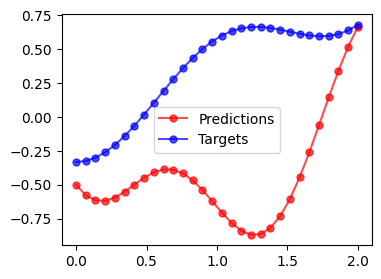

In [6]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

### Model training

In [7]:
for epoch in range(200):
    optimizer.zero_grad()
    
    # Compute loss using the wrapped loss function
    loss = loss_function(model, x_train, y_train)
    
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")

/home/matteo/Documents/PhD/envs/qibo/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0: Loss = 2.764176845550537
Epoch 5: Loss = 0.33419936895370483
Epoch 10: Loss = 0.20971184968948364
Epoch 15: Loss = 0.1789761185646057
Epoch 20: Loss = 0.1440446823835373
Epoch 25: Loss = 0.12442488223314285
Epoch 30: Loss = 0.12567341327667236
Epoch 35: Loss = 0.10619334876537323
Epoch 40: Loss = 0.09792666137218475
Epoch 45: Loss = 0.0832751914858818
Epoch 50: Loss = 0.07019317895174026
Epoch 55: Loss = 0.05243510380387306
Epoch 60: Loss = 0.04021473601460457
Epoch 65: Loss = 0.028335658833384514
Epoch 70: Loss = 0.022880714386701584
Epoch 75: Loss = 0.02114914171397686
Epoch 80: Loss = 0.019572341814637184
Epoch 85: Loss = 0.018623298034071922
Epoch 90: Loss = 0.017725570127367973
Epoch 95: Loss = 0.016723988577723503
Epoch 100: Loss = 0.01584027148783207
Epoch 105: Loss = 0.015056653879582882
Epoch 110: Loss = 0.014361473731696606
Epoch 115: Loss = 0.013737758621573448
Epoch 120: Loss = 0.013160720467567444
Epoch 125: Loss = 0.012593930587172508
Epoch 130: Loss = 0.01202063

### Predictions

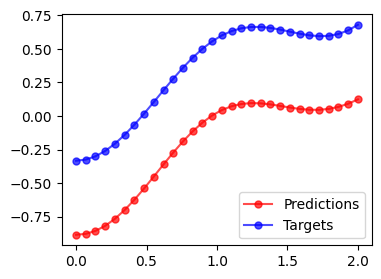

In [8]:
y_pred = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train.detach().numpy(), 
    y_pred.detach().numpy(), 
    marker=".",
    
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x, 
    I,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()

As expected, the solution is good but for a constant value. This is not a problem, because we need to use the model to compute definite integral values as follows:

In [9]:
x_a = torch.tensor(0.01)
x_b = torch.tensor(1.2)

print(
    "Def integral exact:", 
    definite_integral(x_a, x_b)
)
print(
    "Approx integral:", 
     (model(x_b) - model(x_a)).squeeze().detach().numpy()
)

Def integral exact: tensor(0.9921)
Approx integral: 0.9787012075621326
